# P3 : Concevez une application au service de la santé publique

## Notebook nettoyage

Pascaline Grondein

Début de projet : 07/03/2022

Variables décrites ici : https://world.openfoodfacts.org/data/data-fields.txt

### Table of Contents

* [I. Sélection variables et nettoyage](#chapter1)
    * [1 Idée app & variables](#section_1_1)
    * [2 Nettoyage des données](#section_1_2)
         * [a. Erreurs de type](#section_1_2_1)
         * [b.Valeurs manquantes](#section_1_2_2)
            - [Colonnes](#section_1_2_2_1)
            - [Lignes](#section_1_2_2_2)
            - [Traitement valeurs manquantes](#section_1_2_2_3)
         * [c.Doublons](#section_1_2_3)
         * [d.Doublons](#section_1_2_4)
    * [3 Fonction nettoyage](#section_1_3)

In [1]:
#importation librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import urllib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings("ignore")


boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='k')
meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='firebrick')

In [2]:
#import fichier tout en précisant le type de séparation
data = pd.read_csv('fr_openfoodfacts_org_products.csv', sep='\t',decimal='.',low_memory=False)
data.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [3]:
print('Le fichier comporte',data.shape[0],'lignes et',data.shape[1],'colonnes.')

Le fichier comporte 320772 lignes et 162 colonnes.


# <a class="anchor" id="chapter1">I. Sélection variables et nettoyage</a>

## <a class="anchor" id="section_1_1">1. Idée app & variables</a>

Idée app : une app qui donne une note pour l'empreinte carbone du produit, et fournit une note nutrition.

In [4]:
#Lecture et récup du fichier text avec variables
variables = []
   
with open('data-fields.txt') as f:
    variables = f.readlines()  
    
variables

['This file describes the fields from the CSV export of the products in the Open Food Facts database.\n',
 '\n',
 'See https://world.openfoodfacts.org/data for more information.\n',
 '\n',
 'The file encoding is Unicode UTF-8. The character that separates fields is <tab> (tabulation).\n',
 '\n',
 'Generalities:\n',
 '\n',
 '- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)\n',
 '- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ\n',
 '- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)\n',
 '- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language\n',
 '- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product\n',
 '- fields that end with _serving correspond to the amount of a nutriment (

Pour l'app : 

Général :
 - code
 - url
 - product_name
 - generic_name
 - brands
 - brands_tags
 - categories
 - categories_tag
 - countries_fr
 - main_category_fr

Nutrition (ACP) : 
 - energy-kj_100g
 - energy-kcal_100g
 - nutrition-score-fr_100g
 - nutrition_grade_fr
 - proteins_100g
 - carbohydrates_100g
 - sugars_100g
 - fat_100g
 - saturated-fat_100g
 - sodium_100g
 
Empreinte carbone : 
 - origins & tags : pour le made in france
 - labels & tag : pour le made in france
 - manufacturing_places & tags
 - packaging :  pour le tri/empreinte carbone
 - first_packaging_code_geo
 - ingredients_from_palm_oil, ingredients_that_may_be_from_palm_oil
 - carbon-footprint_100g
 

In [6]:
#selection des variables que nous voulons prendre en compte pour l'app
data_subset = data[['code','url','product_name','generic_name','brands','brands_tags','categories','categories_tags','countries_fr','main_category_fr','nutrition-score-fr_100g','proteins_100g','carbohydrates_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','origins','origins_tags','labels','labels_tags','manufacturing_places','manufacturing_places_tags','packaging','first_packaging_code_geo','ingredients_from_palm_oil','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil','ingredients_that_may_be_from_palm_oil_n','additives_n','carbon-footprint_100g','emb_codes','emb_codes_tags','traces','nutrition_grade_fr']]
#data_subset

## <a class="anchor" id="section_1_2">2. Nettoyage des données</a>

### <a class="anchor" id="section_1_2_1">a. Erreurs de type</a>

In [7]:
# vérification du type
data_subset.dtypes

code                                        object
url                                         object
product_name                                object
generic_name                                object
brands                                      object
brands_tags                                 object
categories                                  object
categories_tags                             object
countries_fr                                object
main_category_fr                            object
nutrition-score-fr_100g                    float64
proteins_100g                              float64
carbohydrates_100g                         float64
sugars_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
sodium_100g                                float64
origins                                     object
origins_tags                                object
labels                         

Certaines variables ne sont pas au bon format. 

In [9]:
data_subset.astype({'ingredients_from_palm_oil': 'object','ingredients_that_may_be_from_palm_oil':'object',}).dtypes

code                                        object
url                                         object
product_name                                object
generic_name                                object
brands                                      object
brands_tags                                 object
categories                                  object
categories_tags                             object
countries_fr                                object
main_category_fr                            object
nutrition-score-fr_100g                    float64
proteins_100g                              float64
carbohydrates_100g                         float64
sugars_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
sodium_100g                                float64
origins                                     object
origins_tags                                object
labels                         

### <a class="anchor" id="section_1_2_2">b. Valeurs manquantes</a>

Etapes : 
   - Filtre valeurs manquantes colonnes
   - Filtre valeurs manquantes lignes
   - Traitement valeurs manquantes (variables numériques et quantitatives)

#### <a class="anchor" id="section_1_2_2_1">Colonnes</a>

Ce fichier comporte 6013187 valeurs manquantes.


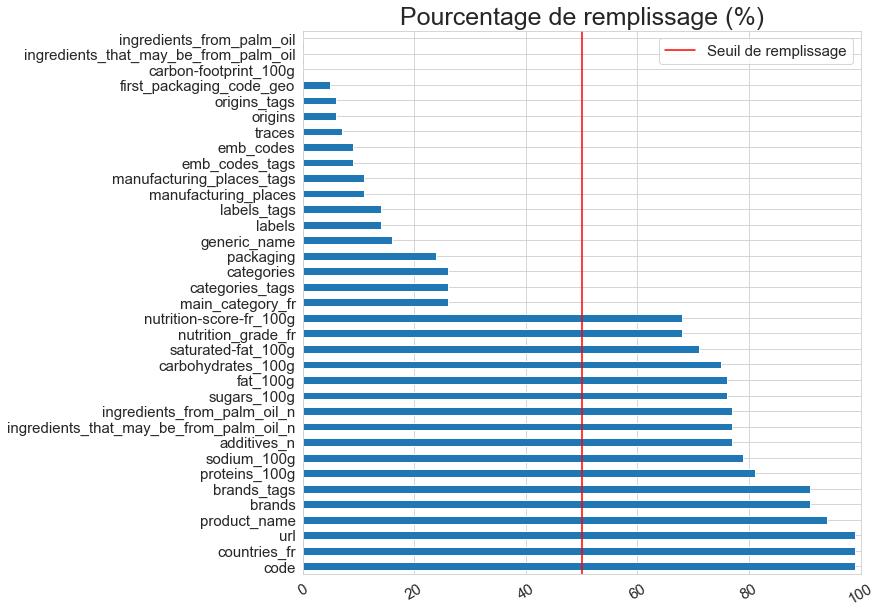

In [10]:
#On fixe le seuil de données manquante
pct_seuil = 50

#On collecte le nombre de valeurs manquanets par variable
nb_na = data_subset.isnull().sum() 
print ('Ce fichier comporte',nb_na.sum(),'valeurs manquantes.' )

#On calcule le pourcentage de valeurs manquantes par variabels
index = data_subset.index
pct_remplissage = pd.DataFrame((100-((nb_na/len(index))*100)).astype(int), columns=['Pourcentage de remplissage (%)']) 

#On trace les pourcentages de valeurs manquantes, en retirant les variables avec un pourcentages nul ou supérieur au seuil
sns.set_style("whitegrid")
pct_remplissage.sort_values('Pourcentage de remplissage (%)', ascending=False).plot.barh(x=None, y=None,xlim = [0,100],legend=False,figsize = (10,10))
plt.title("Pourcentage de remplissage (%)",fontsize = 25)
plt.xticks(rotation=30, horizontalalignment="center",fontsize = 15)
plt.yticks(fontsize = 15)
line_seuil = plt.axvline(x=pct_seuil, color='r', linestyle='-')
plt.legend([line_seuil],['Seuil de remplissage'],prop={"size":15})
plt.show()

In [11]:
pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] > 50]

,Pourcentage de remplissage (%)
code,99
url,99
product_name,94
brands,91
brands_tags,91
countries_fr,99
nutrition-score-fr_100g,68
proteins_100g,81
carbohydrates_100g,75
sugars_100g,76


In [12]:
pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] > pct_seuil].index

Index(['code', 'url', 'product_name', 'brands', 'brands_tags', 'countries_fr',
       'nutrition-score-fr_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'additives_n',
       'nutrition_grade_fr'],
      dtype='object')

In [13]:
#On recupère 
data_subset_test = data_subset.drop(columns=[col for col in data_subset if col in pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] < pct_seuil].index])
data_subset_test.head(3)

,code,url,product_name,brands,brands_tags,countries_fr,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,nutrition_grade_fr
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,Banana Chips Sweetened (Whole),NaN,NaN,États-Unis,14.0,3.57,64.29,14.29,28.57,28.57,0.00,0.0,0.0,0.0,d
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,Peanuts,Torn & Glasser,torn-glasser,États-Unis,0.0,17.86,60.71,17.86,17.86,0.00,0.25,0.0,0.0,0.0,b


#### <a class="anchor" id="section_1_2_2_2">Lignes</a>

In [14]:
#On collecte le nombre de valeurs manquanets par variable
nb_na_row = data_subset_test.isnull().sum(axis=1) 

#On calcule le pourcentage de valeurs manquantes par lignes
columns = data_subset_test.columns
pct_remplissage = pd.DataFrame((100-((nb_na_row/len(columns))*100)).astype(int), columns=['Pourcentage de remplissage (%)']) 

#on retire les lignes avec un taux de remplissage inf au seuil
data_subset_test_2 = data_subset_test.drop(pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] < pct_seuil].index)
data_subset_test_2.head(3)

,code,url,product_name,brands,brands_tags,countries_fr,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,nutrition_grade_fr
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,Banana Chips Sweetened (Whole),NaN,NaN,États-Unis,14.0,3.57,64.29,14.29,28.57,28.57,0.000,0.0,0.0,0.0,d
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,Peanuts,Torn & Glasser,torn-glasser,États-Unis,0.0,17.86,60.71,17.86,17.86,0.00,0.250,0.0,0.0,0.0,b
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,Organic Salted Nut Mix,Grizzlies,grizzlies,États-Unis,12.0,17.86,17.86,3.57,57.14,5.36,0.482,0.0,0.0,0.0,d


#### <a class="anchor" id="section_1_2_2_3">Traitement valeurs manquantes</a>

On remplace les valeurs nulles par la valeur la plus fréquente pour les valeur qualitatives, par la moyenne pour les valeurs quantitatives.

In [15]:
data_subset_test_2.isnull().sum()

code                                           0
url                                            0
product_name                                3088
brands                                      5371
brands_tags                                 5372
countries_fr                                  65
nutrition-score-fr_100g                    53158
proteins_100g                              15037
carbohydrates_100g                         31404
sugars_100g                                29542
fat_100g                                   31111
saturated-fat_100g                         44865
sodium_100g                                19016
ingredients_from_palm_oil_n                26220
ingredients_that_may_be_from_palm_oil_n    26220
additives_n                                26220
nutrition_grade_fr                         53158
dtype: int64

In [16]:
# Traitement par remplacement par mode et médiane ou Iterative Imputer 

string_col = list(data_subset_test_2.select_dtypes(include=['O']).columns)
numeric_col = list(data_subset_test_2._get_numeric_data())

#Variables qualitatives
for column in string_col:
    data_subset_test_2[column] = data_subset_test_2[column].fillna(data_subset_test_2[column].mode().iloc[0])

#Variables quantitatives    
itimp = 0 #1 si iterative imputer method
if itimp == 0:
    for column in numeric_col:
        med = data_subset_test_2[column].median()
        data_subset_test_2[column] = data_subset_test_2[column].fillna(med)
        
if itimp == 1 :
    
    #Variables _n
    data_subset_test_2_n = data_subset_test_2[numeric_col].filter(regex='_n')
    for column in data_subset_test_2_n:
        med = data_subset_test_2_n[column].median()
        data_subset_test_2_n[column] = data_subset_test_2_n[column].fillna(med)
    
    data_subset_test_2.drop(labels=data_subset_test_2_n.columns, axis="columns", inplace=True)
    data_subset_test_2[data_subset_test_2_n.columns] = data_subset_test_2_n[data_subset_test_2_n.columns]

    #Variables _100g
    data_subset_test_2_100g = data_subset_test_2[numeric_col].filter(regex='_100g')
    imputer = IterativeImputer(sample_posterior=True,tol = 0.1,max_iter = 10,random_state=0,n_nearest_features=None, imputation_order='ascending',missing_values = np.nan)
    imputed = imputer.fit_transform(data_subset_test_2_100g)
    data_subset_test_2_imputed = pd.DataFrame(imputed, columns=df_100g.columns)             
    
    data_subset_test_2.drop(labels=data_subset_test_2_100g.columns, axis="columns", inplace=True)
    data_subset_test_2[data_subset_test_2_100g.columns] = data_subset_test_2_imputed[data_subset_test_2_100g.columns]
    
data_subset_test_2.isnull().sum()

code                                       0
url                                        0
product_name                               0
brands                                     0
brands_tags                                0
countries_fr                               0
nutrition-score-fr_100g                    0
proteins_100g                              0
carbohydrates_100g                         0
sugars_100g                                0
fat_100g                                   0
saturated-fat_100g                         0
sodium_100g                                0
ingredients_from_palm_oil_n                0
ingredients_that_may_be_from_palm_oil_n    0
additives_n                                0
nutrition_grade_fr                         0
dtype: int64

### <a class="anchor" id="section_1_2_3">c. Doublons</a> 

In [17]:
data_subset_test_2.loc[data_subset_test_2['code'].duplicated(keep=False),:]

,code,url,product_name,brands,brands_tags,countries_fr,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,nutrition_grade_fr


### <a class="anchor" id="section_1_2_4">d. Valeurs aberrantes</a>

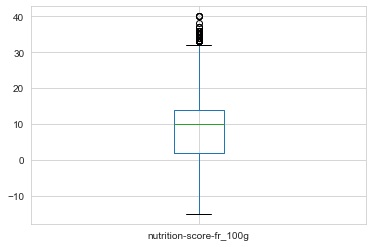

In [18]:
data_subset_test_2.boxplot(column="nutrition-score-fr_100g")
plt.show()

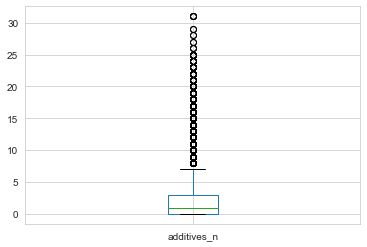

In [19]:
data_subset_test_2.boxplot(column="additives_n")
plt.show()

Pour les valeurs aberrantes ont utilise la méthode du capping.

Limites pour les variables quantitatives : 

 - _100g : 0 à 100 
 - sauf nutriscore entre -15 et 40
 - _n : méthode interquartile

On normalise les données numériques pour les plots sur le même graphe. 

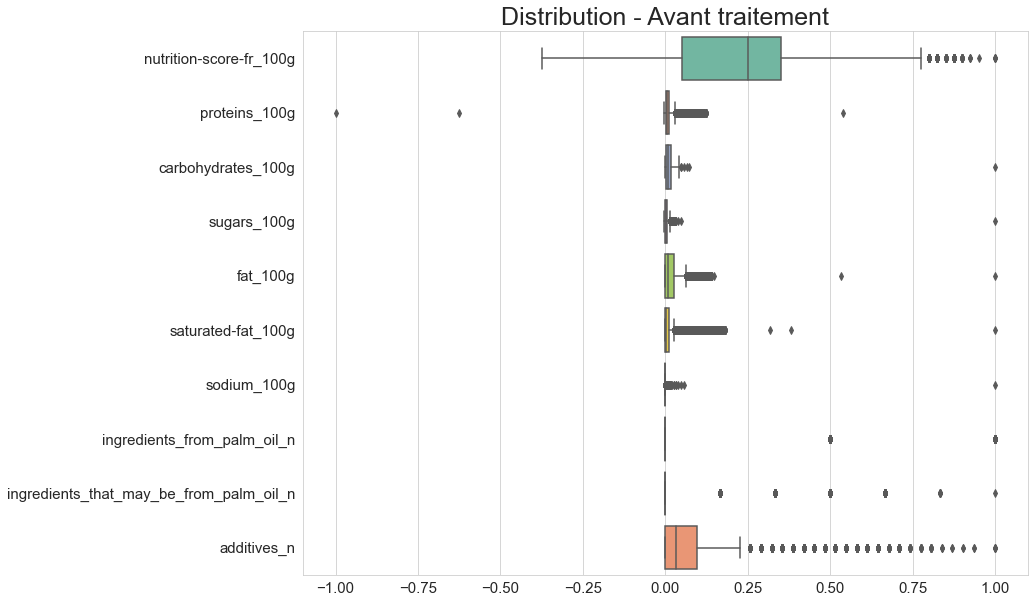

In [20]:
df = data_subset_test_2.sample(frac = 1)
df_num = df.select_dtypes(include='number')
df_norm = (df_num/df_num.abs().max())

sns.set_style("whitegrid")
plt.figure(figsize=(13,10))
ax = sns.boxplot(data=df_norm, orient="h", palette="Set2")
plt.title('Distribution - Avant traitement',fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [21]:
df_num.describe()

,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n
count,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000
mean,9.328638,6.948274,30.773401,14.887947,11.851615,4.582901,0.757861,0.017771,0.050006,1.849446
std,8.137926,8.188602,28.206288,21.319994,16.718660,7.430121,48.732213,0.133736,0.256639,2.396400
min,-15.000000,-800.000000,0.000000,-17.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.830000,7.060000,1.790000,0.200000,0.000000,0.032708,0.000000,0.000000,0.000000
50%,10.000000,4.760000,20.690000,5.710000,5.000000,1.790000,0.229000,0.000000,0.000000,1.000000
75%,14.000000,9.700000,54.600000,20.000000,17.860000,6.000000,0.511811,0.000000,0.000000,3.000000
max,40.000000,430.000000,2916.670000,3520.000000,714.290000,550.000000,25320.000000,2.000000,6.000000,31.000000


In [22]:
lower_percentile = 0.05
higher_percentile = 0.95
cap = df_num.quantile([lower_percentile, higher_percentile])
cap

,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n
0.05,-4.0,0.00,0.00,0.0,0.0000,0.00,0.0,0.0,0.0,0.0
0.95,23.0,23.21,80.95,60.0,43.3225,18.75,1.5,0.0,0.0,7.0


In [23]:
for column in df_num.filter(regex='_100g'): 
    if column == 'nutrition-score-fr_100g':
        df.loc[df[column] < -15] = -15            
        df.loc[df[column] > 40] = 40
    else :   
        df.loc[df[column] < 0] = 0
        df.loc[df[column] > 100] = 100
            
        
for column in df_num.filter(regex='_n'):
    cap = df.filter(regex='_n').quantile([lower_percentile, higher_percentile])
    low = cap.at[cap.index[0],column]
    high = cap.at[cap.index[1],column]
    df.loc[df[column] < low] = low
    df.loc[df[column] > high] = high
    

In [24]:
df.describe()

,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n
count,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000
mean,8.470528,6.677543,27.193562,13.263023,11.023222,4.368834,0.815184,0.242121,0.242121,1.476364
std,8.089807,7.939456,27.313244,19.378555,16.423203,7.199764,2.740778,1.180723,1.180723,1.765211
min,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.420000,5.260000,1.100000,0.000000,0.000000,0.015000,0.000000,0.000000,0.000000
50%,10.000000,4.760000,19.850000,5.710000,5.000000,1.790000,0.229000,0.000000,0.000000,1.000000
75%,14.000000,9.090000,50.000000,15.000000,15.790000,6.000000,0.549000,0.000000,0.000000,2.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6.000000,6.000000,6.000000


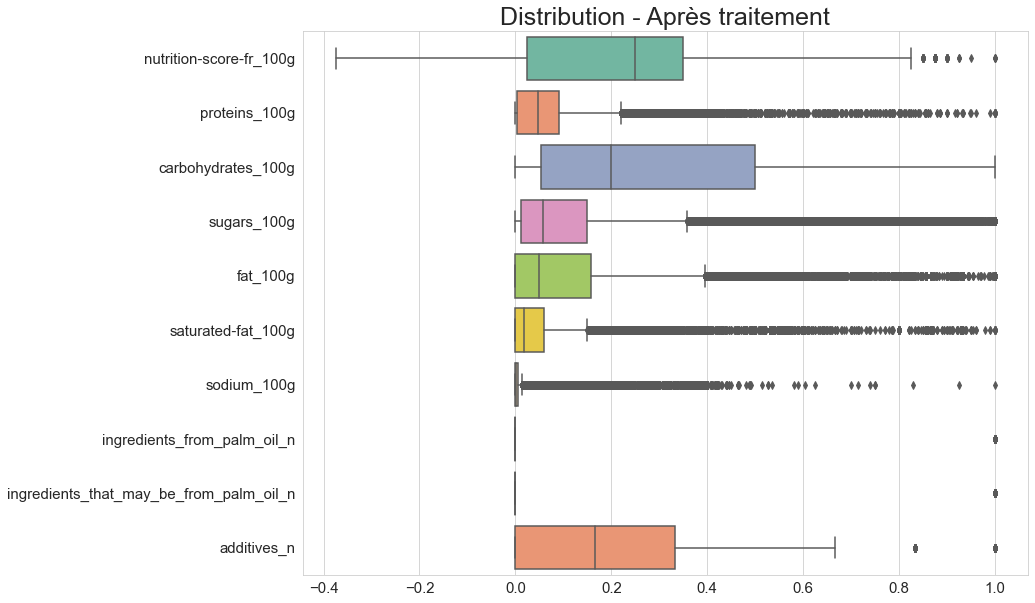

In [25]:
df_num = df.select_dtypes(include='number')
df_norm = (df_num/df_num.abs().max())

sns.set_style("whitegrid")
plt.figure(figsize=(13,10))
ax = sns.boxplot(data=df_norm, orient="h", palette="Set2")
plt.title('Distribution - Après traitement',fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

##  <a class="anchor" id="section_1_3">3. Fonction nettoyage</a>

In [26]:
def nettoyage(df,pct_seuil_col, pct_seuil_row,itimp,higher_percentile,lower_percentile): 
    #pct_seuil_col : seuil de remplissage pour les colonnes en %
    #pct_seuil_row : seuil de remplissage pour les lignes en %
    #itimp : Iterative Imputation for numeric values, 1 si inactif, 0 sinon
    #higher_percentile : seuil haut pour le capping
    #lower_percentile : seuil bas pour le capping
    
    
    
    #VALEURS MANQUANTES COLONNES
    print('VALEURS MANQUANTES SUR COLONNES')
      
    #On collecte le nombre de valeurs manquanets par variable
    nb_na = df.isnull().sum() 
    print ('Le dataframe comporte',df.shape[0],'lignes et',df.shape[1],'colonnes, ainsi que',nb_na.sum(),'valeurs manquantes.' )

    #On calcule le pourcentage de valeurs manquantes par variables
    index = df.index
    pct_remplissage = pd.DataFrame((100-((nb_na/len(index))*100)).astype(int), columns=['Pourcentage de remplissage (%)']) 

    #On trace les pourcentages de valeurs manquantes
    sns.set_style("whitegrid")
    pct_remplissage.sort_values('Pourcentage de remplissage (%)', ascending=False).plot.barh(x=None, y=None,xlim = [0,100],legend=False,figsize = (13,13))
    plt.title("Pourcentage de remplissage (%)",fontsize = 25)
    plt.xticks(rotation=30, horizontalalignment="center",fontsize = 15)
    plt.yticks(fontsize = 15)
    line_seuil = plt.axvline(x=pct_seuil_col, color='r', linestyle='-')
    plt.legend([line_seuil],['Seuil de remplissage'],prop={"size":15})
    plt.show()
    
    #on retire les variables avec un taux de remplissage inf au seuil
    vardrop = pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] < pct_seuil_col]
    print(len(vardrop),' variables ont un taux de remplissage sous',pct_seuil_col,'%.')
    df = df.drop(columns=[col for col in df if col in pct_remplissage.loc[pct_remplissage['Pourcentage de remplissage (%)'] < pct_seuil_col].index])
    
    
    #VALEURS MANQUANTES LIGNES
    print('-----')
    print('VALEURS MANQUANTES SUR LIGNES')
    
    #On collecte le nombre de valeurs manquanets par variable
    nb_na_row = df.isnull().sum(axis=1) 
    print ('Le dataframe comporte désormais',df.shape[0],'lignes et',df.shape[1],'colonnes, ainsi que',nb_na_row.sum(),'valeurs manquantes.' )

    #On calcule le pourcentage de valeurs manquantes par lignes
    columns = df.columns
    pct_remplissage_row = pd.DataFrame((100-((nb_na_row/len(columns))*100)).astype(int), columns=['Pourcentage de remplissage (%)']) 
        
    
    #on retire les lignes avec un taux de remplissage inf au seuil
    rowdrop = pct_remplissage_row.loc[pct_remplissage_row['Pourcentage de remplissage (%)'] < pct_seuil_row]
    print(len(rowdrop),' lignes ont un taux de remplissage sous',pct_seuil_row,'%.')
    df = df.drop(pct_remplissage_row.loc[pct_remplissage_row['Pourcentage de remplissage (%)'] < pct_seuil_row].index)
    
    
    
    
    #TRAITEMENT VALEURS MANQUANTES
    str_ = list(df.select_dtypes(include=['O']).columns)
    num_ = list(df._get_numeric_data())
    
    for column in str_:
        df[column] = df[column].fillna(df[column].mode().iloc[0])
        
    if itimp == 0:
        
        for column in num_:
            med = df[column].median()
            df[column] = df[column].fillna(med)
            
            
    if itimp == 1 :
        
        #Variables _n
        df_n = df[num_].filter(regex='_n')
        for column in df_n:
            med = df_n[column].median()
            df_n[column] = df_n[column].fillna(med)
        
        df.drop(labels=df_n.columns, axis="columns", inplace=True)
        df[df_n.columns] = df_n[df_n.columns]

        
        #Variables _100g
        df_100g = df[num_].filter(regex='_100g')
        imputer = IterativeImputer(sample_posterior=True,tol = 0.1,max_iter = 10,random_state=0,n_nearest_features=None, imputation_order='ascending',missing_values = np.nan)
        imputed = imputer.fit_transform(df_100g)
        df_imputed = pd.DataFrame(imputed, columns=df_100g.columns)   
        #round(df_imputed, 2) 
        
        df.drop(labels=df_100g.columns, axis="columns", inplace=True)
        df[df_100g.columns] = df_imputed[df_100g.columns]
        
           
     
        
        
    #TRAITEMENT DES DOUBLONS
    print('-----')
    print('DOUBLONS')
    
    dup = df.loc[df['code'].duplicated(keep=False),:]
    print('Le dataframe comporte',len(dup),'doublons.')
    if len(dup) != 0:
        df = df.drop_duplicates().reset_index(drop=True)

   
    
    
    #VALEURS ABERRANTES
    print('-----')
    print('VALEURS ABERRANTES')
    print('   ')
    print('   ')
    print('---Avant traitement---')
    display(df.describe())
    
    num_ = list(df._get_numeric_data())
    df_num = df[num_]
    
    #PLOT
    #pour trier par médiane
    #meds_norm = df_norm.median()
    #meds_norm.sort_values(ascending=False, inplace=True)
    #df_norm = df_norm[meds_norm.index]
    
    #sns.set_style("whitegrid")
    #plt.figure(figsize=(13,10))
    #ax = sns.boxplot(data=df_norm, orient="h", palette="Set2")
    #plt.title('Outlier - Avant traitement',fontsize = 25)
    #plt.xticks(fontsize = 15)
    #plt.yticks(fontsize = 15)
    #plt.show()



    #Traitement variables numérique
    #Valeurs nutritionnelles
    for column in df_num.filter(regex='_100g'):
        #print(column)
        if column == 'nutrition-score-fr_100g':
            df_num.loc[df_num[column] < -15] = -15
            df_num.loc[df_num[column] > 40] = 40
        else :   
            df_num.loc[df_num[column] < 0] = 0
            df_num.loc[df_num[column] > 100] = 100
            
    #Variables homogènes        
    for column in df_num.filter(regex='_n'):
        cap = df_num.filter(regex='_n').quantile([lower_percentile, higher_percentile])
        low = cap.at[cap.index[0],column]
        high = cap.at[cap.index[1],column]
        df_num.loc[df_num[column] < low] = low
        df_num.loc[df_num[column] > high] = high
        
    df.drop(labels=num_, axis="columns", inplace=True)
    df[num_] = df_num[num_]
    
    print('   ')
    print('   ')
    print('---Après traitement---')
    display(df.describe())
    
    
    #PLOT
    #pour trier par médiane
    #meds_norm = df_norm.median()
    #meds_norm.sort_values(ascending=False, inplace=True)
    #df_norm = df_norm[meds_norm.index]
    
    #sns.set_style("whitegrid")
    #plt.figure(figsize=(13,10))
    #ax = sns.boxplot(data=df_norm, orient="h", palette="Set2")
    #plt.title('Outlier - Avant traitement',fontsize = 25)
    #plt.xticks(fontsize = 15)
    #plt.yticks(fontsize = 15)
    #plt.show()   
            
    df = df.reset_index(drop=True)
    
    return df

In [27]:
#selection des variables que nous voulons prendre en compte pour l'app
data_subset = data[['code','url','product_name','generic_name','brands','brands_tags','categories','categories_tags','countries_fr','main_category_fr','nutrition-score-fr_100g','proteins_100g','carbohydrates_100g','sugars_100g','fat_100g','saturated-fat_100g','sodium_100g','origins','origins_tags','labels','labels_tags','manufacturing_places','manufacturing_places_tags','packaging','first_packaging_code_geo','ingredients_from_palm_oil','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil','ingredients_that_may_be_from_palm_oil_n','additives_n','carbon-footprint_100g','emb_codes','emb_codes_tags','traces','nutrition_grade_fr']]
data_subset.astype({'ingredients_from_palm_oil': 'object','ingredients_that_may_be_from_palm_oil':'object',}).dtypes

code                                        object
url                                         object
product_name                                object
generic_name                                object
brands                                      object
brands_tags                                 object
categories                                  object
categories_tags                             object
countries_fr                                object
main_category_fr                            object
nutrition-score-fr_100g                    float64
proteins_100g                              float64
carbohydrates_100g                         float64
sugars_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
sodium_100g                                float64
origins                                     object
origins_tags                                object
labels                         

#### Version sans It Impt 

VALEURS MANQUANTES SUR COLONNES
Le dataframe comporte 320772 lignes et 35 colonnes, ainsi que 6013187 valeurs manquantes.


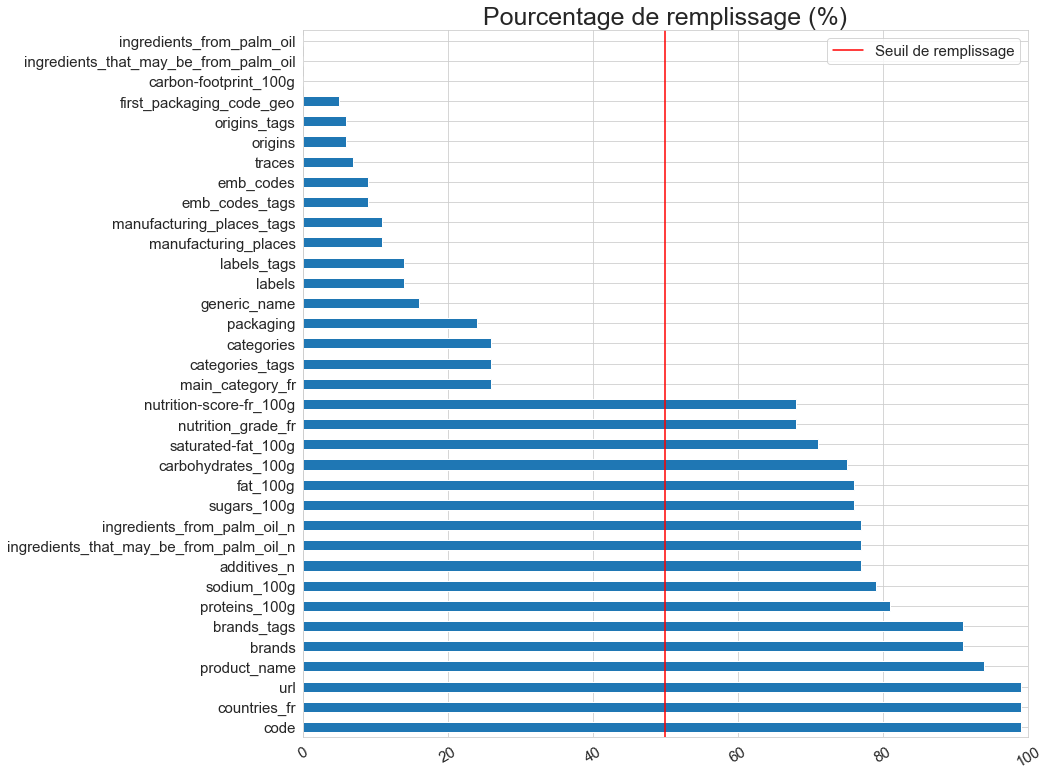

18  variables ont un taux de remplissage sous 50 %.
-----
VALEURS MANQUANTES SUR LIGNES
Le dataframe comporte désormais 320772 lignes et 17 colonnes, ainsi que 936786 valeurs manquantes.
46446  lignes ont un taux de remplissage sous 50 %.
-----
DOUBLONS
Le dataframe comporte 0 doublons.
-----
VALEURS ABERRANTES
   
   
---Avant traitement---


,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n
count,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000
mean,9.328638,6.948274,30.773401,14.887947,11.851615,4.582901,0.757861,0.017771,0.050006,1.849446
std,8.137926,8.188602,28.206288,21.319994,16.718660,7.430121,48.732213,0.133736,0.256639,2.396400
min,-15.000000,-800.000000,0.000000,-17.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.830000,7.060000,1.790000,0.200000,0.000000,0.032708,0.000000,0.000000,0.000000
50%,10.000000,4.760000,20.690000,5.710000,5.000000,1.790000,0.229000,0.000000,0.000000,1.000000
75%,14.000000,9.700000,54.600000,20.000000,17.860000,6.000000,0.511811,0.000000,0.000000,3.000000
max,40.000000,430.000000,2916.670000,3520.000000,714.290000,550.000000,25320.000000,2.000000,6.000000,31.000000


   
   
---Après traitement---


,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n
count,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000,274326.000000
mean,8.470528,6.677543,27.193562,13.263023,11.023222,4.368834,0.815184,0.242121,0.242121,1.476364
std,8.089807,7.939456,27.313244,19.378555,16.423203,7.199764,2.740778,1.180723,1.180723,1.765211
min,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.420000,5.260000,1.100000,0.000000,0.000000,0.015000,0.000000,0.000000,0.000000
50%,10.000000,4.760000,19.850000,5.710000,5.000000,1.790000,0.229000,0.000000,0.000000,1.000000
75%,14.000000,9.090000,50.000000,15.000000,15.790000,6.000000,0.549000,0.000000,0.000000,2.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6.000000,6.000000,6.000000


In [28]:
data_test = nettoyage(data_subset,pct_seuil_col = 50, pct_seuil_row = 50, itimp = 0,higher_percentile = 0.95,lower_percentile = 0.05)

#### Version avec It Imp 

VALEURS MANQUANTES SUR COLONNES
Le dataframe comporte 320772 lignes et 35 colonnes, ainsi que 6013187 valeurs manquantes.


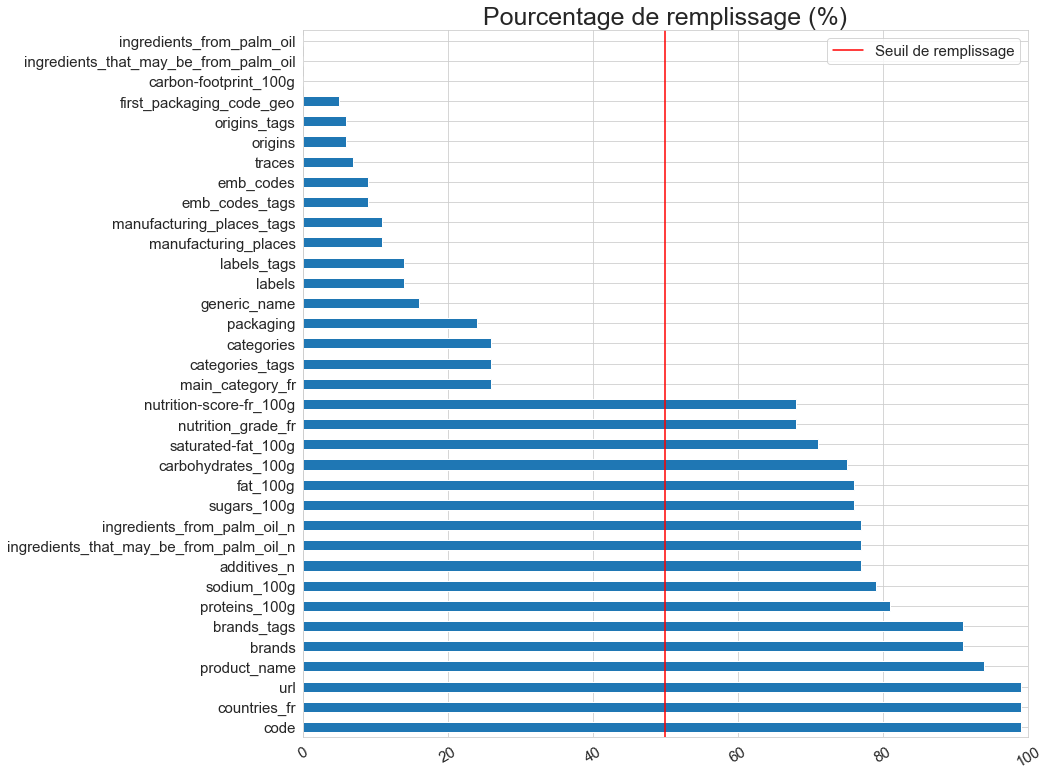

18  variables ont un taux de remplissage sous 50 %.
-----
VALEURS MANQUANTES SUR LIGNES
Le dataframe comporte désormais 320772 lignes et 17 colonnes, ainsi que 936786 valeurs manquantes.
46446  lignes ont un taux de remplissage sous 50 %.
-----
DOUBLONS
Le dataframe comporte 0 doublons.
-----
VALEURS ABERRANTES
   
   
---Avant traitement---


,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
count,274326.000000,274326.000000,274326.000000,243373.000000,243373.000000,243373.000000,243373.000000,243373.000000,243373.000000,243373.000000
mean,0.017771,0.050006,1.849446,9.021379,7.043278,32.271249,15.560825,12.754527,4.697453,0.824771
std,0.133736,0.256639,2.396400,9.226948,8.310535,30.585926,22.614561,17.682085,7.882598,53.214992
min,0.000000,0.000000,0.000000,-24.307852,-500.000000,-83.440579,-85.099116,-275.249126,-85.860388,-185.585686
25%,0.000000,0.000000,0.000000,1.000000,0.600000,6.450000,1.180000,0.000000,0.000000,0.019000
50%,0.000000,0.000000,1.000000,9.000000,4.760000,22.310000,6.190000,5.650000,1.850100,0.232283
75%,0.000000,0.000000,3.000000,16.000000,10.200000,57.800000,24.400000,20.936387,7.140000,0.577000
max,2.000000,6.000000,31.000000,152.660311,430.000000,3243.903751,3520.000000,714.290000,550.000000,25320.000000


   
   
---Après traitement---


,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,additives_n,nutrition-score-fr_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,sodium_100g
count,274326.000000,274326.000000,274326.000000,247568.000000,247568.000000,247568.000000,247568.000000,247568.000000,247568.000000,247568.000000
mean,0.217340,0.217340,1.319627,7.597421,6.019633,26.606774,12.969584,10.471224,4.199911,1.089041
std,1.121074,1.121074,1.732040,8.771321,7.718155,28.787247,19.595246,15.353482,6.680794,5.135995
min,0.000000,0.000000,0.000000,-14.674274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,6.000000,3.570000,13.030000,3.570000,3.330000,1.000000,0.143000
75%,0.000000,0.000000,2.000000,14.000000,8.400000,51.670000,17.320376,16.670000,6.000000,0.533000
max,6.000000,6.000000,6.000000,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.978921


In [29]:
data_itimp = nettoyage(data_subset,pct_seuil_col = 50, pct_seuil_row = 50, itimp = 1,higher_percentile = 0.95,lower_percentile = 0.05)